# Focusing apodized grating coupler

**Running the entire notebook costs more than 1 FlexCredit.**

In this notebook, we will design a focusing apodized grating coupler (GC) to vertically couple light in/out photonic integrated circuits (PICs). We will build the grating coupler following the design guidelines presented in the following paper: R. Marchetti, C. Lacava, A. Khokhar, et al. "High-efficiency grating-couplers: demonstration of a new design strategy," Sci Rep 7, 16670 (2017) [DOI: 10.1038/s41598-017-16505-z](https://doi.org/10.1038/s41598-017-16505-z). In a previous case study, we modeled an [uniform grating coupler notebook](../notebooks/GratingCoupler.html). The apodized grating coupler demonstrated in this notebook shows superior performance.

To begin, we import the typical Python packages along with `tidy3d` and its plugins.

In [1]:
# Standard python imports.
import numpy as np
import matplotlib.pylab as plt
import gdstk

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import waveguide


## Grating Coupler Structure

The GC structure is based on a standard silicon-on-insulator (SOI) wafer with a device layer of 220 nm. By linearly varying the fill-factor $F(x) = F_{0} - R\cdot x$, where $F_{0}$ is the fill-factor of the first grating element and $R$ is the apodization factor, the power radiated by the first elements of the grating is reduced, and the mode matching between the output waveguide and the grating section is improved, thus reducing reflections. To further improve the grating coupling efficiency, the grating element size $\Delta$ is let to vary, so satisfying the Bragg condition along the whole grating. 

<center><img src="img/FocusedGC.png" alt="Focused Apodized Grating Coupler"  width="700"/></center>

The effective index of a grating element $n_{eff}(x)$ then depends on the fill-factor $F(x)$, and the mode indices obtained in the etched ($n_{e}$) and non-etched ($n_{o}$) sections of the grating, as 

\begin{equation*}
n_{eff}(x) = F(x)n_{o} + [1 - F(x)]n_{e}.
\tag{1}
\end{equation*}

From the effective index, the size of each grating element can be calculated as:

\begin{equation*}
\Delta(x) = \frac{\lambda_{0}}{n_{e} - n_{c}sin(\theta_{gc}) + F(x)\Delta n}
\tag{2}
\end{equation*}

where $\lambda_{0}$ is the center wavelength, $n_{c}$ is the cladding refractive index, $\theta_{gc}$ is the light incidence angle with respect to the grating normal, and $\Delta n = n_{o} - n_{e}$. 

A focusing design of GC is usually adopted to reduce device footprint. In this way, the grating lines (indicated by an integer $q$) are curved forming ellipses with common focal points, as in Eq. 3 (`Ralf Waldhäusl, Bernd Schnabel, Peter Dannberg, Ernst-Bernhard Kley, Andreas Bräuer, and Wolfgang Karthe, "Efficient Coupling into Polymer Waveguides by Gratings," Appl. Opt. 36, 9383-9390 (1997)`[DOI: 10.1364/AO.36.009383](https://doi.org/10.1364/AO.36.009383)).

\begin{equation*}
q\lambda_{0} = n_{eff}\sqrt{x^{2} + y^{2}} - xn_{c}sin(\theta_{f}).
\tag{3}
\end{equation*}

For simplicity, we will approximate the grating lines by concentric circles, which is a reasonable assumption considering small incidence angles.

In [2]:
# Grating coupler set up.
h_dev = 0.220  # Device layer thickness (um).
h_box = 2.0  # BOX layer thickness (um).
h_clad = 0.78  # Cladding layer thickness (um).
h_sub = 0.8  # Silicon substrate thickness (um).
etch_d = 0.110  # GC etch depth (um).
alpha_t = 40  # GC taper opening angle (degrees).
tap_l = 16  # Taper length (um).
tap_e = 1  # Additional length after GC elements (um).
n_p = 25  # Number of grating elements.
r_i = 0.0275  # Initial value for the apodization parameter.
min_feature = 0.1  # Minimum feature size (um).
spot_size = 10.4  # Single-mode fiber (SMF) spot-size (um).
theta_f = 14.5  # Fiber tilt angle w.r.t the z-axis (degrees).
src_pos = 5.0  # Source position w.r.t the position of the first GC line (um).
src_offset = 0.05  # Source offset w.r.t GC surface (um).
wg_l = 4  # Output waveguide length (um).
wg_w = 0.5  # Output waveguide width (um).
gc_file = "misc/Focusing_GC.gds"  # File name to export GC GDS file.

# Materials.
n_si = 3.48  # Silicon refractive index.
n_sio2 = 1.44  # SiO2 refractive index.
n_c = 1.44  # Cladding refractive index.

# Simulation set up.
wl = 1.55  # Center simulation wavelength (um).
bw = 0.06  # Simulation wavelength bandwidth (um).
n_wl = 61  # Number of wavelength points in monitors.
run_time = 2e-12  # Run time parameter for simulation (s).


We will calculate and define some parameters used throughout the notebook.

In [3]:
# Material definitions.
mat_si = td.Medium(permittivity=n_si**2)  # Waveguide material.
mat_sio2 = td.Medium(permittivity=n_sio2**2)  # BOX material.
mat_clad = td.Medium(permittivity=n_c**2)  # Cladding material.

# Light incidence angle on the GC.
theta_gc = np.arcsin(np.sin(theta_f * np.pi / 180) / n_c) * 180 / np.pi

# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])


So, let's define some functions to create the grating coupler.


In [4]:
# Function to calculate the values of filling fractions and grating element sizes.
def calc_gc_par(
    no: float = 2.65,
    ne: float = 2.25,
    nc: float = 1.0,
    theta: float = 10.0,
    lamb: float = 1.55,
    N: int = 25,
    R: float = 0.025,
    min_feature: float = 0.140,
):
    del_x = np.zeros((N))
    f_x = np.zeros((N))
    theta_rad = theta * np.pi / 180
    del_0 = lamb / (no - nc * np.sin(theta_rad))
    f_0 = (del_0 - min_feature) / del_0
    x = 0
    for i in range(0, N):
        f_x[i] = f_0 - R * x
        del_x[i] = lamb / (ne - nc * np.sin(theta_rad) + f_x[i] * (no - ne))
        x += del_x[i]

    return (del_x, f_x)


# Function to create the 3D GC structure.
def build_gc(
    del_x: np.ndarray = None,
    f_x: np.ndarray = None,
    alpha_t: float = 40.0,
    tap_l: float = 16,
    tap_e: float = 1,
    etch_d: float = 0.1,
    wg_w: float = 0.50,
    wg_t: float = 0.22,
    wg_l: float = 5,
    gds_file: str = [],
):
    lib = gdstk.Library()
    gc_cell = lib.new_cell("GC")

    alpha_rad = alpha_t * np.pi / 180
    xf = wg_l - ((wg_w / 2 / np.sin(alpha_rad / 2)) * np.cos(alpha_rad / 2))
    yf = 0
    r = tap_l
    # GC taper section.
    gc_slice = gdstk.ellipse(
        (xf, yf),
        r,
        initial_angle=-alpha_rad / 2,
        final_angle=alpha_rad / 2,
        layer=1,
        datatype=1,
        tolerance=0.0005,
    )
    gc_cell.add(gc_slice)
    # GC lines.
    for d, f in zip(del_x, f_x):
        r += d
        ri = r - f * d
        gc_line = gdstk.ellipse(
            (xf, yf),
            r,
            inner_radius=ri,
            initial_angle=-alpha_rad / 2,
            final_angle=alpha_rad / 2,
            layer=1,
            datatype=1,
            tolerance=0.0005,
        )
        gc_cell.add(gc_line)
    # GC extension.
    ri = r
    r += tap_e
    gc_ext = gdstk.ellipse(
        (xf, yf),
        r,
        inner_radius=ri,
        initial_angle=-alpha_rad / 2,
        final_angle=alpha_rad / 2,
        layer=1,
        datatype=1,
        tolerance=0.0005,
    )
    gc_cell.add(gc_ext)
    # GC non-etched material.
    gc_full_slice = gdstk.ellipse(
        (xf, yf),
        r,
        initial_angle=-alpha_rad / 2,
        final_angle=alpha_rad / 2,
        layer=2,
        datatype=2,
        tolerance=0.0005,
    )
    gc_cell.add(gc_full_slice)
    # Input/output waveguide.
    wg_v = [
        (wg_l, -wg_w / 2),
        (-3 * wg_l, -wg_w / 2),
        (-3 * wg_l, +wg_w / 2),
        (wg_l, +wg_w / 2),
    ]
    gc_wg = gdstk.Polygon(wg_v, layer=3, datatype=3)
    gc_cell.add(gc_wg)

    # Build the Tidy3D PolySlab and Structure objects.
    gc_etch = td.PolySlab.from_gds(
        gc_cell, gds_layer=1, axis=2, slab_bounds=(wg_t / 2 - etch_d, wg_t / 2)
    )
    gc_non_etch = td.PolySlab.from_gds(
        gc_cell, gds_layer=2, axis=2, slab_bounds=(-wg_t / 2, wg_t / 2 - etch_d)
    )[0]
    wg = td.PolySlab.from_gds(
        gc_cell, gds_layer=3, axis=2, slab_bounds=(-wg_t / 2, wg_t / 2)
    )[0]
    gc_struct = td.Structure(
        geometry=td.GeometryGroup(geometries=(gc_non_etch, *gc_etch, wg)), medium=mat_si
    )

    # Outputs the GDS file.
    if gds_file:
        lib.write_gds(gds_file)

    return gc_struct


##  Simulation Set Up

We will create a function to build different types of simulations based on the value of `sim_mode`:

- `sim_mode = "sweep"`: *builds an in-coupling simulation using only one mode monitor.*
- `sim_mode = "visualization"`: *builds an in-coupling simulation including field and flux monitors.*
- `sim_mode = "out_coupling"`: *builds an out-coupling simulation using a field projection monitor.*

To define the grating structure, we will perform 2D simulations by running multiple parameter sweeps. Once this is completed, the final response will be obtained using 3D simulations. Details about setting up 2D simulations can be found in the [2D ring resonator notebook](../notebooks/RingResonator.html).

In [5]:
# Function to create the simulation.
def build_sim(
    sim_mode="sweep",
    sim_dim="3D",
    no=2.8,
    ne=2.3,
    nc=1.2,
    src_pos=src_pos,
    R=r_i,
    alpha_t=alpha_t,
    tap_l=tap_l,
    tap_e=tap_e,
    etch_d=etch_d,
    gds_file=[],
):
    # Calculates the GC element sizes and fill-factors.
    del_x, f_x = calc_gc_par(
        no=no,
        ne=ne,
        nc=nc,
        theta=theta_gc,
        lamb=wl,
        N=n_p,
        R=R,
        min_feature=min_feature,
    )

    # GC related parameters.
    gc_offset = (wg_w / np.sin(alpha_t * np.pi / 180)) * np.cos(alpha_t * np.pi / 180)
    gc_0 = wg_l + tap_l - gc_offset
    gc_length = tap_l + np.sum(del_x) + tap_e - gc_offset
    pml_offset = 0.7 * wl
    # Simulation size.
    size_z = h_sub + h_box + h_dev + h_clad + pml_offset
    size_x = wg_l + gc_length + wl
    size_y = 0.95 * gc_length * np.tan(alpha_t * np.pi / 180) if sim_dim == "3D" else 0
    center_z = size_z / 2 - pml_offset - h_clad - h_dev / 2

    # Build the GC structure.
    gc_struct = build_gc(
        del_x=del_x,
        f_x=f_x,
        alpha_t=alpha_t,
        tap_l=tap_l,
        tap_e=tap_e,
        etch_d=etch_d,
        wg_w=wg_w,
        wg_t=h_dev,
        wg_l=wg_l,
        gds_file=gds_file,
    )
    # Box layer.
    _inf = 1000
    sio2_box = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-_inf, -_inf, -h_dev / 2 - h_box), rmax=(_inf, _inf, -h_dev / 2)
        ),
        medium=mat_sio2,
    )
    # Cladding layer.
    cladding = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-_inf, -_inf, -h_dev / 2), rmax=(_inf, _inf, h_dev / 2 + h_clad)
        ),
        medium=mat_clad,
    )
    # Substrate.
    si_sub = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-_inf, -_inf, -_inf), rmax=(_inf, _inf, -h_dev / 2 - h_box)
        ),
        medium=mat_si,
    )

    if sim_mode == "sweep" or sim_mode == "visualization":
        # Gaussian source focused above the grating coupler.
        source = td.GaussianBeam(
            center=(gc_0 + src_pos, 0, h_dev / 2 + h_clad + src_offset),
            size=(
                1.2 * spot_size,
                1.2 * spot_size
                if sim_dim == "3D"
                else td.inf,  # Make it infinity in 2D.
                0,
            ),
            source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
            pol_angle=np.pi / 2,
            angle_theta=theta_f * np.pi / 180.0,
            direction="-",
            num_freqs=7,
            waist_radius=spot_size / 2,
        )
        # Mode monitor.
        mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)
        mode_monitor = td.ModeMonitor(
            center=[0.5 * wl, 0, 0],
            size=[0, 4 * wg_w, 5 * h_dev],
            freqs=freqs,
            mode_spec=mode_spec,
            name="mode_monitor",
        )
        monitors = [mode_monitor]

        if sim_mode == "visualization":
            # Add field and flux monitors.
            field_monitor_xy = td.FieldMonitor(
                center=(size_x / 2, 0, h_dev / 2 - etch_d / 2),
                size=(td.inf, td.inf, 0),
                freqs=[freq],
                name="field_xy",
            )
            monitors.append(field_monitor_xy)
            field_monitor_xz = td.FieldMonitor(
                center=(size_x / 2, 0, 0),
                size=(td.inf, 0, td.inf),
                freqs=[freq],
                name="field_xz",
            )
            monitors.append(field_monitor_xz)
            flux_sub = td.FluxMonitor(
                center=(size_x / 2, 0, -h_dev - h_box),
                size=(td.inf, td.inf, 0),
                freqs=freqs,
                name="flux_sub",
            )
            monitors.append(flux_sub)
            flux_ref = td.FluxMonitor(
                center=(size_x / 2, 0, h_dev + h_clad + src_offset),
                size=(td.inf, td.inf, 0),
                freqs=freqs,
                name="flux_reflected",
            )
            monitors.append(flux_ref)
    else:
        # Define a mode source that injects te fundamental mode.
        mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)
        source = td.ModeSource(
            center=(0.5 * wl, 0, 0),
            size=(0, 4 * wg_w, 5 * h_dev),
            source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
            direction="+",
            mode_spec=mode_spec,
            mode_index=0,
            num_freqs=7,
        )
        # Add a near field monitor.
        field_monitor_xy = td.FieldMonitor(
            center=(size_x / 2, 0, h_dev / 2 + h_clad + src_offset),
            size=(td.inf, td.inf, 0),
            freqs=[freq],
            name="near_field",
        )
        monitors = [field_monitor_xy]
        field_monitor_xz = td.FieldMonitor(
            center=(size_x / 2, 0, 0),
            size=(td.inf, 0, td.inf),
            freqs=[freq],
            name="field_xz",
        )
        monitors.append(field_monitor_xz)
        flux_back = td.FluxMonitor(
            center=(0.25 * wl, 0, 0),
            size=(0, td.inf, td.inf),
            freqs=freqs,
            name="flux_back",
        )
        monitors.append(flux_back)

    # Refine the grid over the GC region.
    refine_box = td.MeshOverrideStructure(
        geometry=td.Box(center=(size_x / 2, 0, 0), size=(td.inf, td.inf, 2 * h_dev)),
        dl=[0.02, 0.02 if sim_dim == "3D" else None, 0.02],
    )

    # Simulation
    sim = td.Simulation(
        center=(size_x / 2, 0, -center_z),
        size=(size_x, size_y, size_z),
        grid_spec=td.GridSpec.auto(
            wavelength=wl,
            min_steps_per_wvl=15,
            override_structures=[refine_box],
        ),
        structures=[si_sub, sio2_box, cladding, gc_struct],
        sources=[source],
        monitors=monitors,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(),
            y=td.Boundary.pml()
            if sim_dim == "3D"
            else td.Boundary.periodic(),  # Make it periodic in 2D.
            z=td.Boundary.pml(),
        ),
        symmetry=(0, -1 if sim_dim == "3D" else 0, 0),
        run_time=run_time,
    )
    return sim


### Grating Coupler Visualization

To verify if everything is correct, we will obtain the parameters $n_{o}$ and $n_{e}$, calculated using the `waveguide` plugin, and then visualize the grating coupler structure.

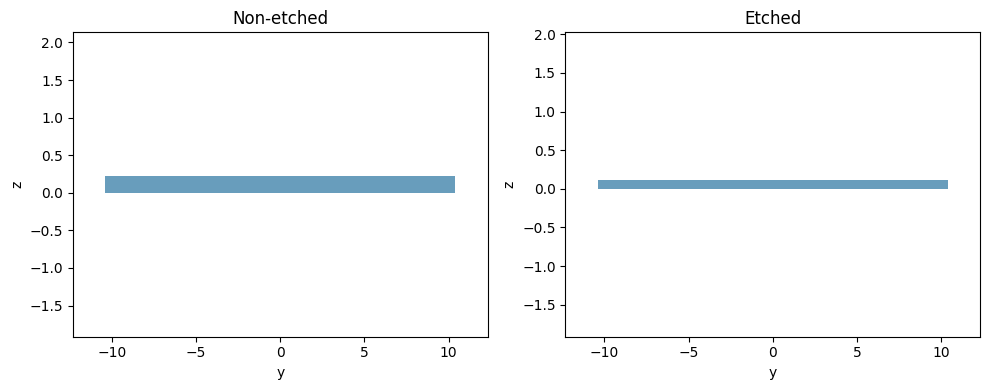

In [6]:
# Definition of wide non-etched and etched waveguides.
wg_non_etch, wg_etch = [
    waveguide.RectangularDielectric(
        wavelength=wl,
        core_width=2 * spot_size,
        core_thickness=t,
        core_medium=mat_si,
        box_medium=mat_sio2,
        clad_medium=mat_clad,
    )
    for t in [h_dev, h_dev - etch_d]
]

# Take a look at the waveguide cross-sections.
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
_ = wg_non_etch.plot_structures(x=0, ax=ax[0])
ax[0].set_aspect("auto")
ax[0].set_title("Non-etched")
_ = wg_etch.plot_structures(x=0, ax=ax[1])
ax[1].set_aspect("auto")
ax[1].set_title("Etched")
plt.show()

Non-etched waveguide effective index: 2.854
Etched waveguide effective index: 2.276


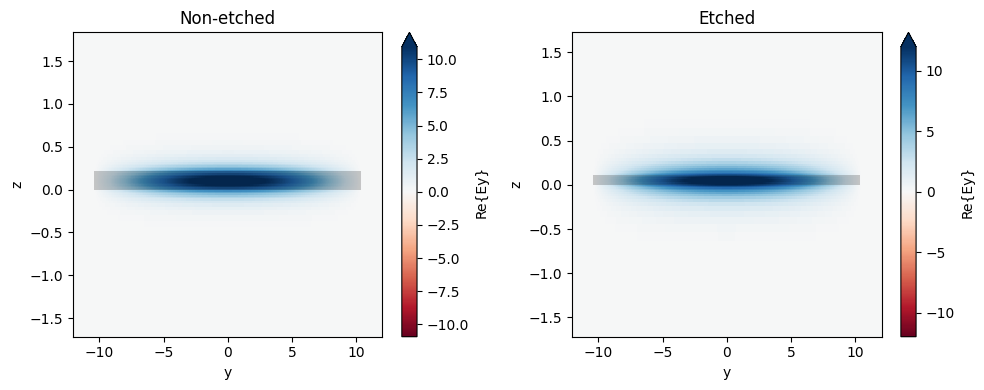

In [7]:
n_o = wg_non_etch.n_eff.values[0, 0]
n_e = wg_etch.n_eff.values[0, 0]
print(f"Non-etched waveguide effective index: {n_o:.3f}")
print(f"Etched waveguide effective index: {n_e:.3f}")

# Take a look at the waveguide fields.
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
wg_non_etch.plot_field("Ey", mode_index=0, ax=ax[0])
ax[0].set_aspect("auto")
ax[0].set_title("Non-etched")
wg_etch.plot_field("Ey", mode_index=0, ax=ax[1])
ax[1].set_aspect("auto")
ax[1].set_title("Etched")
plt.show()

Let's visualize both the 2D and 3D versions of the simulation.

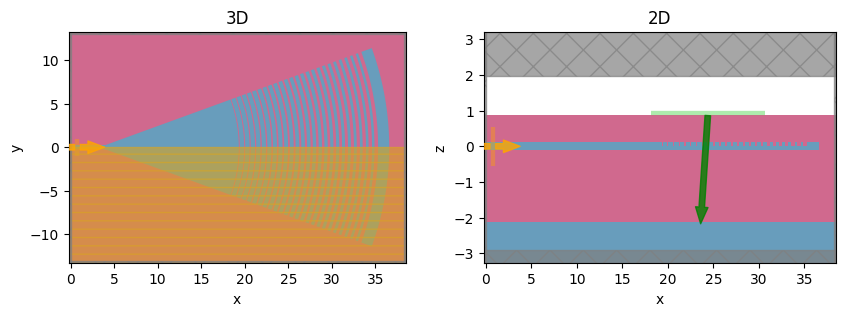

In [8]:
sim_3d = build_sim(
    sim_mode="sweep",
    sim_dim="3D",
    no=n_o,
    ne=n_e,
    nc=n_c,
    src_pos=src_pos,
    R=r_i,
    alpha_t=alpha_t,
    tap_l=tap_l,
    tap_e=tap_e,
    etch_d=etch_d,
)

sim_2d = build_sim(
    sim_mode="sweep",
    sim_dim="2D",
    no=n_o,
    ne=n_e,
    nc=n_c,
    src_pos=src_pos,
    R=r_i,
    alpha_t=alpha_t,
    tap_l=tap_l,
    tap_e=tap_e,
    etch_d=etch_d,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.0))
sim_3d.plot(z=h_dev / 2 - etch_d / 2, ax=ax1)
ax1.set_title("3D")
sim_2d.plot(y=0, ax=ax2)
ax2.set_aspect("auto")
ax2.set_title("2D")
plt.show()


## Definition of Grating Coupler Structure

Now, we will vary the GC etch depth and the apodization parameter to maximize the coupling efficiency (CE). At each iteration, a source position sweep is performed to find the maximum CE, so totalizing `len(etch_d_vals)`$\times$`len(R_vals)`$\times$`len(src_pos_vals)` simulations. 

In [9]:
etch_d_vals = np.linspace(0.07, 0.14, 8)
R_vals = np.linspace(0.015, 0.035, 6)
src_pos_vals = np.linspace(4.0, 6.0, 5)
print(f"Number of simulations: {len(etch_d_vals)*len(R_vals)*len(src_pos_vals):d}")


Number of simulations: 240


As expected, the effective index decays as the etch depth increases.

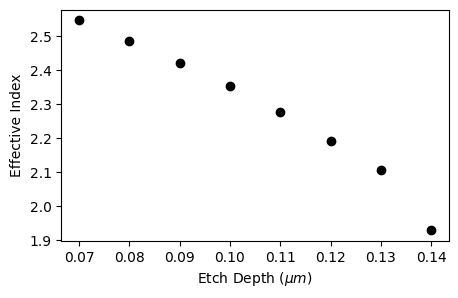

In [10]:
n_e_vals = np.zeros_like(etch_d_vals)
for i, ed in enumerate(etch_d_vals):
    wg_e = waveguide.RectangularDielectric(
        wavelength=wl,
        core_width=2 * spot_size,
        core_thickness=h_dev - ed,
        core_medium=mat_si,
        box_medium=mat_sio2,
        clad_medium=mat_clad,
    )
    n_e_vals[i] = wg_e.n_eff.values[0, 0]

fig, ax = plt.subplots(1, figsize=(5, 3))
ax.plot(etch_d_vals, n_e_vals, "o", color="black")
ax.set_xlabel("Etch Depth ($\mu m$)")
ax.set_ylabel("Effective Index")
plt.show()


Next, we will build and run the parameter sweep using [web.run_async]((../notebooks/ParameterScan.html)). Verbosity will be turned off to reduce the amount of output data.

In [11]:
sim_sweep = {
    f"sim_etch_d:{ed}_R:{r}_src_pos:{sp}": build_sim(
        sim_mode="sweep",
        sim_dim="2D",
        no=n_o,
        ne=ne,
        nc=n_c,
        src_pos=sp,
        R=r,
        alpha_t=alpha_t,
        tap_l=tap_l,
        tap_e=tap_e,
        etch_d=ed,
    )
    for ed, ne in zip(etch_d_vals, n_e_vals)
    for r in R_vals
    for sp in src_pos_vals
}

batch_data = web.run_async(simulations=sim_sweep, path_dir="data", verbose=False)


After completing batch simulation, we will calculate and analyze the data.

In [12]:
ce_vals = np.ones((R_vals.size, etch_d_vals.size)) * (-1000)
src_vals = np.zeros_like(ce_vals)

for k, ed in enumerate(etch_d_vals):
    for j, r in enumerate(R_vals):
        for i, sp in enumerate(src_pos_vals):
            sim_data = batch_data[f"sim_etch_d:{ed}_R:{r}_src_pos:{sp}"]
            mode_amps = sim_data["mode_monitor"]
            coeffs_f = mode_amps.amps.sel(direction="-")
            power = np.abs(coeffs_f.sel(mode_index=0)) ** 2
            power_db = np.asarray(np.amax(10 * np.log10(power)))
            if ce_vals[j, k] < power_db:
                ce_vals[j, k] = power_db
                src_vals[j, k] = sp


A CE value of -1.9 dB is obtained for an etch depth of 0.09 $\mu m$, R = 0.031 $\mu^{-1}$, and the source positioned at 5 $\mu m$. The next figure shows the higher values of CE with respect to etch depth and R.

Etch depth: 0.090
R: 0.031
Source position: 5.000


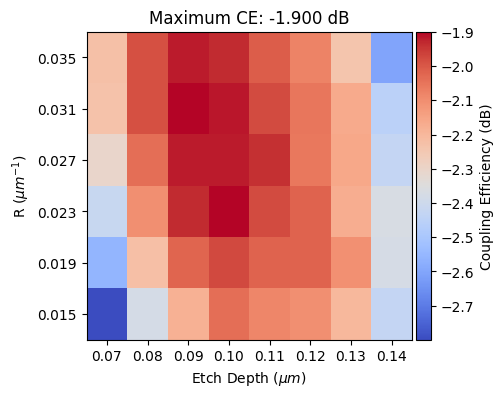

In [13]:
jr, ke = np.where(ce_vals == ce_vals.max())
final_etch_d = etch_d_vals[ke][0]
final_R = R_vals[jr][0]
final_src_pos = src_vals[jr, ke][0]
ce_2d = ce_vals[jr, ke][0]

print(f"Etch depth: {final_etch_d:.3f}")
print(f"R: {final_R:.3f}")
print(f"Source position: {final_src_pos:.3f}")

fig, ax = plt.subplots(1, figsize=(5, 4))
pcm = ax.pcolormesh(
    etch_d_vals,
    R_vals,
    ce_vals,
    shading="nearest",
    cmap="coolwarm",
    vmin=np.amin(ce_vals),
    vmax=np.amax(ce_vals),
)
ax.set_xticks(etch_d_vals)
ax.set_yticks(R_vals)
ax.set_title(f"Maximum CE: {ce_2d:.3f} dB")
ax.set_xlabel("Etch Depth ($\mu m$)")
ax.set_ylabel("R ($\mu m^{-1}$)")
fig.colorbar(pcm, ax=ax, label="Coupling Efficiency (dB)", pad=0.01)
plt.show()


## Final Grating Coupler Response

Based on the parameters obtained in the previous section, we will build a 3D GC structure and calculate its response. A GDS file with the final layout will be output to `gc_file`.

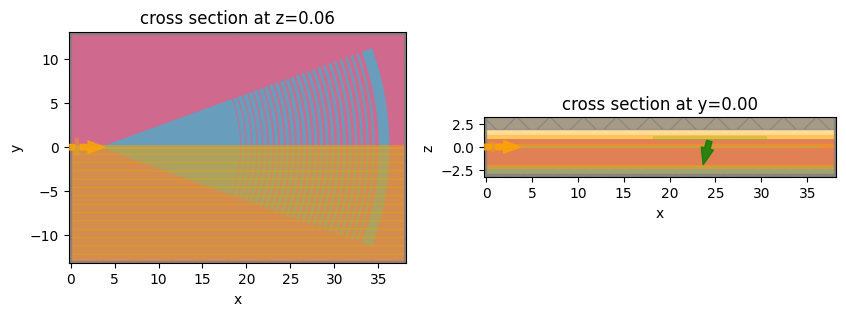

In [14]:
sim_3d = build_sim(
    sim_mode="visualization",
    sim_dim="3D",
    no=n_o,
    ne=n_e_vals[ke],
    nc=n_c,
    src_pos=final_src_pos,
    R=final_R,
    alpha_t=alpha_t,
    tap_l=tap_l,
    tap_e=tap_e,
    etch_d=final_etch_d,
    gds_file=gc_file,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.0))
sim_3d.plot(z=h_dev / 2 - etch_d / 2, ax=ax1)
sim_3d.plot(y=0, ax=ax2)
plt.show()


In [16]:
job = web.Job(simulation=sim_3d, task_name="gc_in_coupling_3d", verbose=False)
sim_3d_in = job.run(path="data/gc3d_in_data.hdf5")

The CE of the 3D GC is lower than the 2D GC version only by 0.2 dB. The larger source of loss is the transmitted power into the silicon substrate.

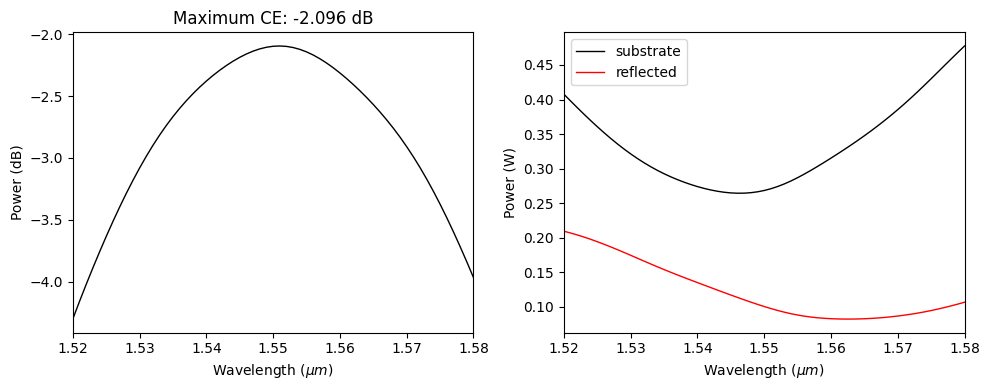

In [17]:
# Coupling Efficiency
mode_amps = sim_3d_in["mode_monitor"]
coeffs_f = mode_amps.amps.sel(direction="-")
power = np.abs(coeffs_f.sel(mode_index=0)) ** 2
power_db = 10 * np.log10(power)
ce_3d = np.amax(power_db)
# Fluxes
power_sub = abs(sim_3d_in["flux_sub"].flux)
power_ref = abs(sim_3d_in["flux_reflected"].flux)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
ax1.plot(wl_range, power_db, color="black", linestyle="solid", linewidth=1.0)
ax1.set_xlim([wl_range[0], wl_range[-1]])
ax1.set_xlabel("Wavelength ($\mu m$)")
ax1.set_ylabel("Power (dB)")
ax1.set_title(f"Maximum CE: {ce_3d:.3f} dB")

ax2.plot(
    wl_range,
    power_sub,
    color="black",
    linestyle="solid",
    linewidth=1.0,
    label="substrate",
)
ax2.plot(
    wl_range,
    power_ref,
    color="red",
    linestyle="solid",
    linewidth=1.0,
    label="reflected",
)
ax2.set_xlim([wl_range[0], wl_range[-1]])
ax2.set_xlabel("Wavelength ($\mu m$)")
ax2.set_ylabel("Power (W)")
ax2.legend()
plt.show()


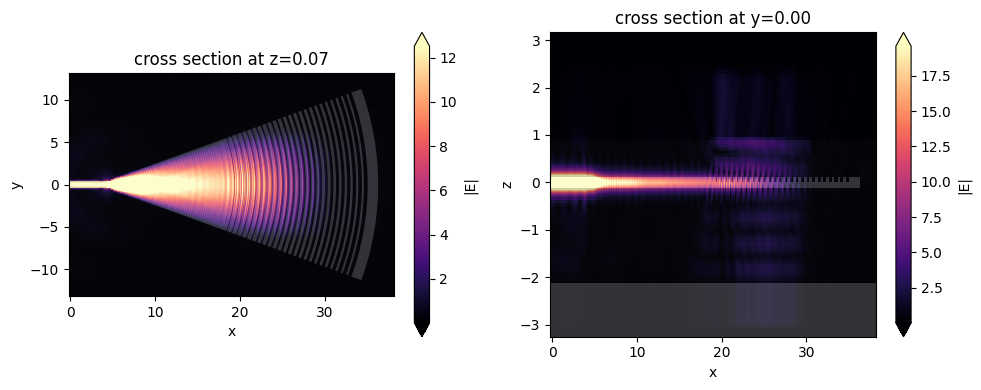

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim_3d_in.plot_field("field_xy", "E", f=freq, val="abs", ax=ax1)
sim_3d_in.plot_field("field_xz", "E", f=freq, val="abs", ax=ax2)
ax2.set_aspect("auto")
plt.show()


### Out-coupling Configuration

After obtaining the in-coupling response, we will build the same GC structure using the out-coupling configuration and run a final simulation.

In [19]:
sim_3d_o = build_sim(
    sim_mode="out_coupling",
    sim_dim="3D",
    no=n_o,
    ne=n_e_vals[ke],
    nc=n_c,
    src_pos=final_src_pos,
    R=final_R,
    alpha_t=alpha_t,
    tap_l=tap_l,
    tap_e=tap_e,
    etch_d=final_etch_d,
    gds_file=gc_file,
)

job = web.Job(simulation=sim_3d_o, task_name="gc_out_coupling_3d", verbose=False)
sim_3d_out = job.run(path="data/gc3d_out_data.hdf5")


First, let's visualize the field at the $xz$ plane and above the GC cladding layer. As one can see, most of the power is scattered upwards. This fact and the lower values of back reflections confirm the effectiveness of the apodization method in improving the GC efficiency.

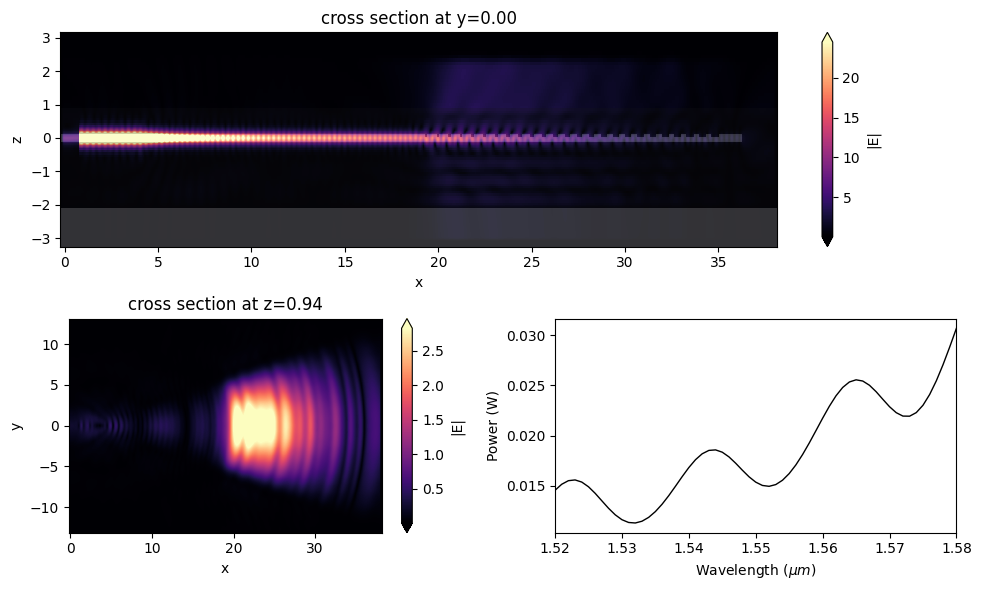

In [20]:
power_back = abs(sim_3d_out["flux_back"].flux)

fig = plt.figure(tight_layout=True, figsize=(10, 6))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
sim_3d_out.plot_field("field_xz", "E", f=freq, val="abs", ax=ax1)
ax1.set_aspect("auto")
sim_3d_out.plot_field("near_field", "E", f=freq, val="abs", ax=ax2)
ax3.plot(wl_range, power_back, color="black", linestyle="solid", linewidth=1.0)
ax3.set_xlim([wl_range[0], wl_range[-1]])
ax3.set_xlabel("Wavelength ($\mu m$)")
ax3.set_ylabel("Power (W)")
plt.show()


Finally, we will use the Tidy3D’s FieldProjector to compute the angular dependence of the far field scattering based on the near field monitor. The same approach presented and detailed in the [uniform grating coupler notebook](../notebooks/GratingCoupler.html) is used here.

In [21]:
# Creates a range of angles to probe.
num_angles = 1101
thetas = np.linspace(-np.pi / 2, np.pi / 2, num_angles)

# Make a near-to-far monitor specifying the observation angles and frequencies of interest.
monitor_n2f = td.FieldProjectionAngleMonitor(
    center=sim_3d_o.monitors[0].center,
    size=sim_3d_o.monitors[0].size,
    normal_dir="+",
    freqs=[freq],
    theta=thetas,
    phi=[0.0],
    name="n2f",
)

# Make a near field to far field projector with the near field monitor data
near_field_surface = td.FieldProjectionSurface(
    monitor=sim_3d_o.monitors[0], normal_dir="+"
)
n2f = td.FieldProjector(sim_data=sim_3d_out, surfaces=[near_field_surface])

# Compute the far_fields
far_fields = n2f.project_fields(monitor_n2f)

# Compute the scattered cross section
ps = np.abs(far_fields.radar_cross_section.sel(f=freq).values[0, ...])


Output()

A remarkable agreement between the target angle and the GC emission angle is obtained.

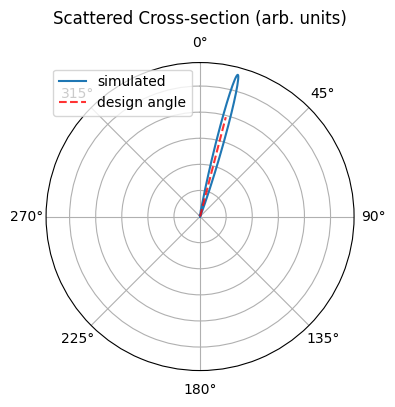

In [22]:
# plot the angle dependence
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(4, 4))
ax.plot(thetas, ps, label="simulated")
ax.plot(
    [theta_f * np.pi / 180, theta_f * np.pi / 180],
    [0, np.max(ps) * 0.7],
    "r--",
    alpha=0.8,
    label="design angle",
)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_title("Scattered Cross-section (arb. units)", va="bottom")
plt.legend()
plt.show()
